In [ ]:
def fasterquant(
        self, blocksize=128, percdamp=0.01, groupsize=-1, actorder=False
    ):
        W = ops.transpose(ops.cast(self.layer.kernel, "float32"))
        H = ops.cast(self.H, "float32")

        if actorder:
            perm = ops.argsort(-ops.diagonal(H))
            W = ops.take(W, perm, axis=1)
            H = ops.take(ops.take(H, perm, axis=0), perm, axis=1)
            invperm = ops.argsort(perm)

        diag_H = ops.diagonal(H)
        dead = ops.equal(diag_H, 0.0)
        diag_H = ops.where(dead, 1.0, diag_H)
        H = H + ops.diag(ops.where(dead, 1.0, ops.zeros_like(diag_H)))
        damp = percdamp * ops.mean(diag_H)
        diag_H = diag_H + damp
        H = (H - ops.diag(ops.diagonal(H))) + ops.diag(diag_H)

        L = ops.linalg.cholesky(H)
        L_inv = ops.linalg.inv(L)
        Hinv = ops.matmul(ops.transpose(L_inv), L_inv)

        Q = ops.zeros_like(W)

        for i1 in range(0, self.rows, blocksize):
            i2 = min(i1 + blocksize, self.rows)
            count = i2 - i1

            W1 = W[:, i1:i2]
            Q1 = ops.zeros_like(W1)
            Err1 = ops.zeros_like(W1)
            Hinv1 = Hinv[i1:i2, i1:i2]

            for i in range(count):
                w = W1[:, i]
                d = Hinv1[i, i]

                if groupsize != -1:
                    if (i1 + i) % groupsize == 0:
                        self.quantizer.find_params(
                            W[:, (i1 + i) : (i1 + i + groupsize)], weight=True
                        )
                else:
                    self.quantizer.find_params(
                        ops.expand_dims(w, 1), weight=True
                    )

                q = quantize(
                    ops.expand_dims(w, 1),
                    self.quantizer.scale,
                    self.quantizer.zero,
                    self.quantizer.maxq,
                )[:, 0]

                Q1 = ops.concatenate(
                    [Q1[:, :i], ops.expand_dims(q, 1), Q1[:, i + 1 :]], axis=1
                )
                err = (w - q) / d
                Err1 = ops.concatenate(
                    [Err1[:, :i], ops.expand_dims(err, 1), Err1[:, i + 1 :]],
                    axis=1,
                )

                if i < count - 1:
                    update = ops.matmul(
                        ops.expand_dims(err, 1),
                        ops.expand_dims(Hinv1[i, i + 1 :], 0),
                    )
                    W1 = ops.concatenate(
                        [W1[:, : i + 1], W1[:, i + 1 :] - update], axis=1
                    )

            Q = ops.concatenate([Q[:, :i1], Q1, Q[:, i2:]], axis=1)

            if i2 < self.rows:
                update_total = ops.matmul(Err1, Hinv[i1:i2, i2:])
                W = ops.concatenate(
                    [W[:, :i2], W[:, i2:] - update_total], axis=1
                )

        if actorder:
            Q = ops.take(Q, invperm, axis=1)

        Q = ops.transpose(Q)

        if isinstance(self.original_layer, EinsumDense):
            Q = ops.reshape(Q, self.kernel_shape)

        new_weights = [ops.convert_to_numpy(Q)]
        if self.original_layer.bias is not None:
            new_weights.append(ops.convert_to_numpy(self.original_layer.bias))

        self.original_layer.set_weights(new_weights)

Final Perplexity: 78.4132

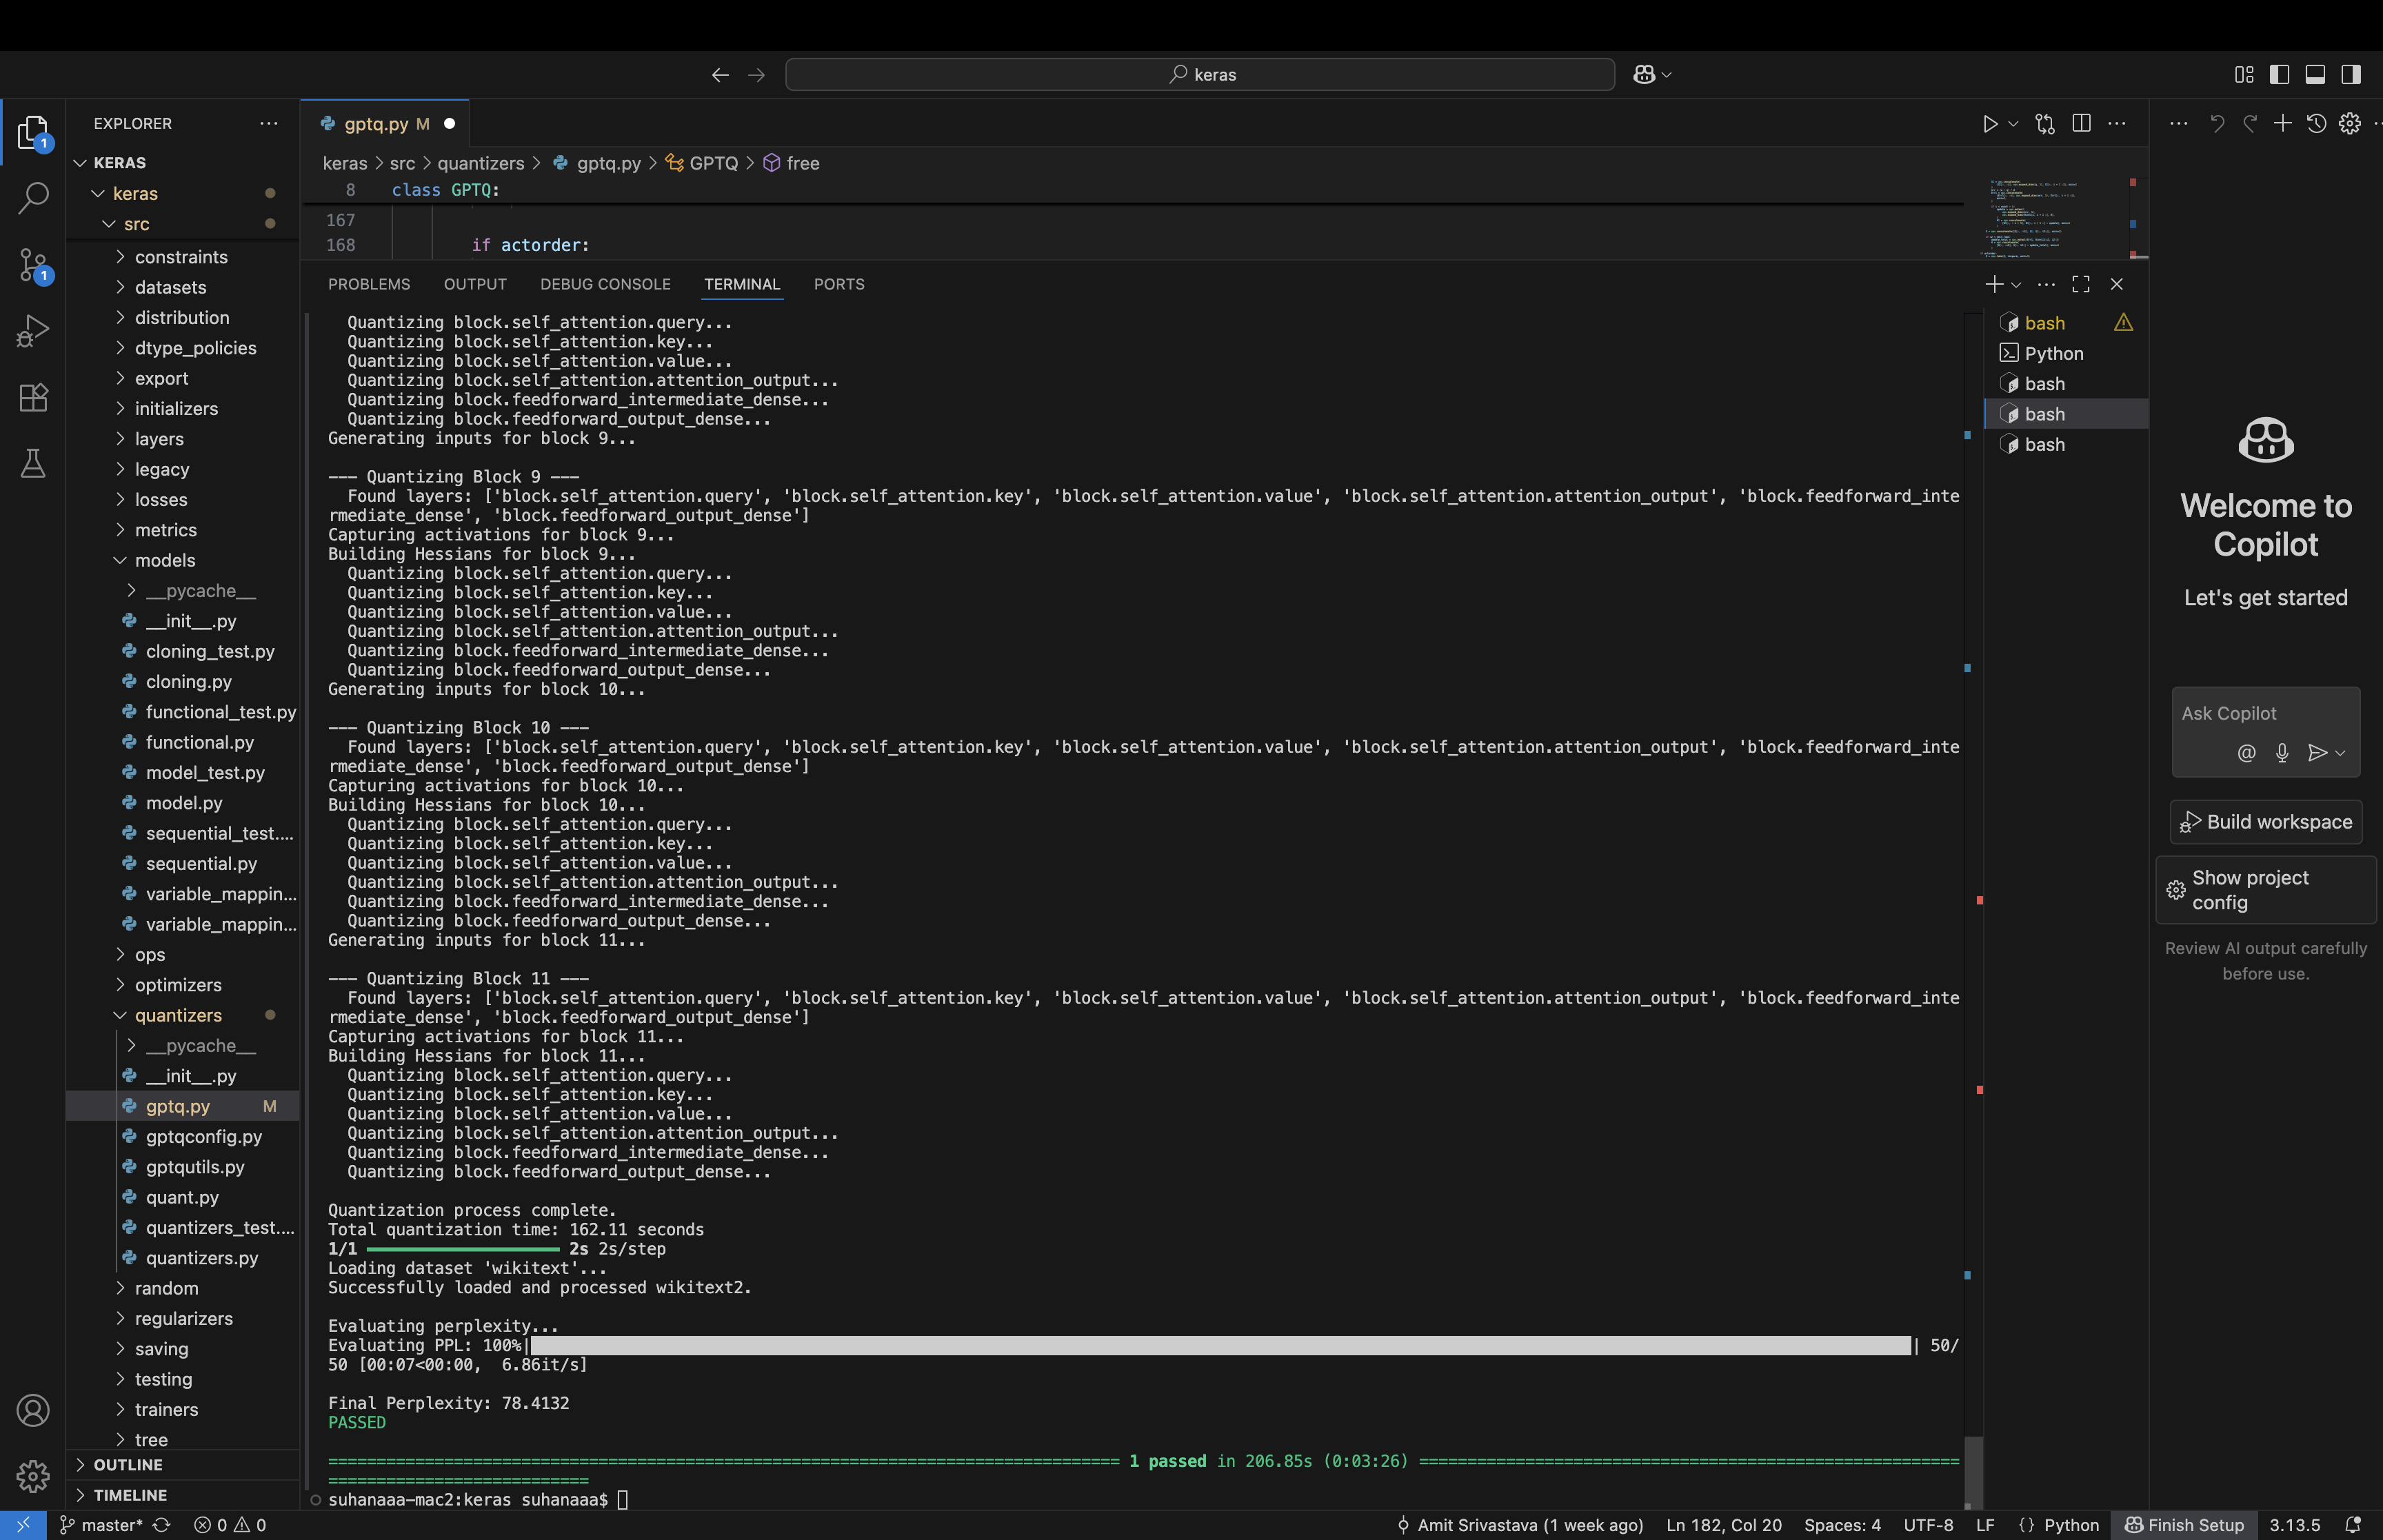